# What is the relationship between store size, number of employees and revenue?
Cian

Import required modules, basic setup

In [1]:
import numpy as np
import pandas as pd
import pyodbc
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap

rcParams["figure.figsize"] = (7, 7) # default plot size
sns.set_context("talk") # default label size etc.

Connect to AdventureWorks database & retrieve data

In [2]:
query = """
SELECT BusinessEntityID AS id
      ,AnnualRevenue AS annual_revenue
      ,SquareFeet AS square_footage
      ,NumberEmployees AS employee_count
  FROM Sales.vStoreWithDemographics
"""

conn = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=SNAP-DECISIONS\SQLEXPRESS;"
    "Database=AdventureWorks2019;"
    "Trusted_Connection=yes;"
)
store = pd.read_sql(query, conn)
store.head()

,id,annual_revenue,square_footage,employee_count
0,292,80000.0,21000,13
1,294,80000.0,18000,14
2,296,80000.0,21000,15
3,298,80000.0,18000,16
4,300,80000.0,21000,17


Alternative data source from CSV

In [3]:
store.to_csv("Q6_data.csv", index=False)
# store = pd.read_csv("Q4_data.csv")

# Data Understanding

Check DataFrame shape

In [4]:
store.shape

(701, 4)

Generate an overview of the dataframe

In [5]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              701 non-null    int64  
 1   annual_revenue  701 non-null    float64
 2   square_footage  701 non-null    int64  
 3   employee_count  701 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 22.0 KB


In [6]:
store.describe().round(1)

,id,annual_revenue,square_footage,employee_count
count,701.0,701.0,701.0,701.0
mean,1035.9,158473.6,40014.3,40.5
std,477.7,98095.2,24445.6,29.5
min,292.0,30000.0,6000.0,2.0
25%,642.0,80000.0,20000.0,16.0
50%,992.0,150000.0,37000.0,35.0
75%,1342.0,300000.0,72000.0,64.0
max,2051.0,300000.0,80000.0,100.0


In [7]:
store.nunique()

id                701
annual_revenue      5
square_footage     39
employee_count     76
dtype: int64

Check for null values

In [8]:
na_in_columns = store.isna().sum()

if na_in_columns.sum() > 0:
    print(f"NA count: {na_in_columns.sum()}")

    columns_with_na = store.columns[na_in_columns == 1]
    print(f"Column(s) containing NA: {', '.join(columns_with_na)}")
else:
    print("No NA values")

No NA values


Check for duplicate values in id column, which should be unique

In [9]:
print(f"Duplicate row count: {store.duplicated(subset='id').sum()}")

Duplicate row count: 0


### Observations:
* Very small number of possible values for **annual_revenue** due to AdventureWorks being a generated database. Revenue is technically continuous data, so will be treated as such for this analysis

# Data Preparation

**id** is categorical rather than numerical data

In [10]:
store['id'] = store['id'].astype("category")

# Exploratory Data Analysis
Pairwise relationships between variables

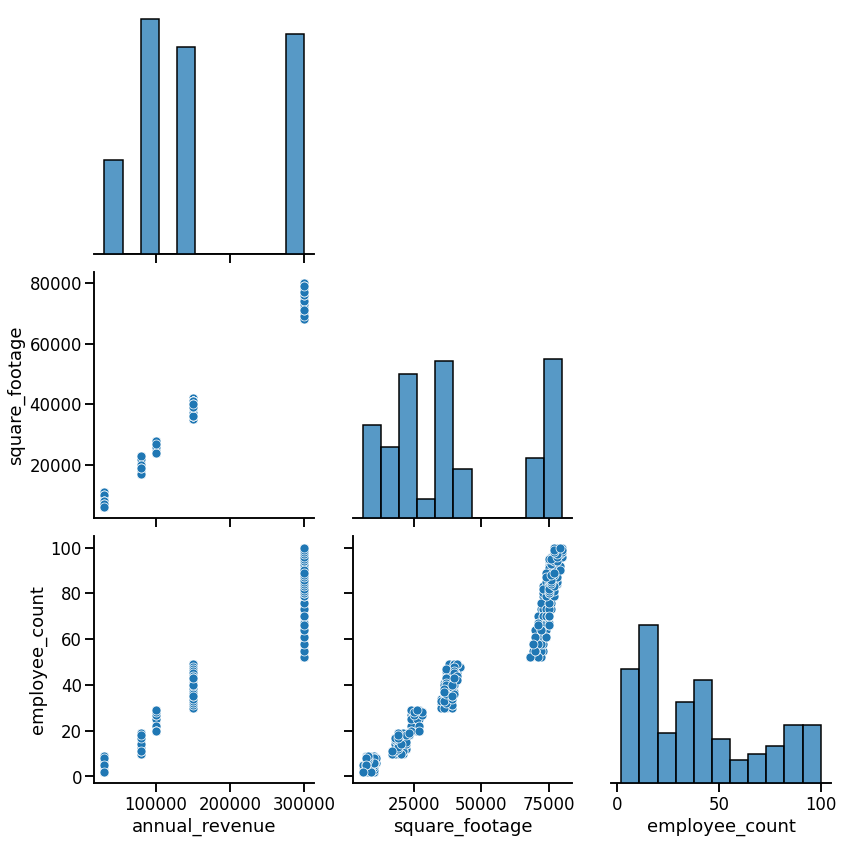

In [11]:
sns.pairplot(
    data=store,
    corner=True,
    height=4,
    aspect=1
)

Correlation heatmap

In [12]:
correlation = store.corr()
correlation

,annual_revenue,square_footage,employee_count
annual_revenue,1.000000,0.996531,0.958107
square_footage,0.996531,1.000000,0.971782
employee_count,0.958107,0.971782,1.000000


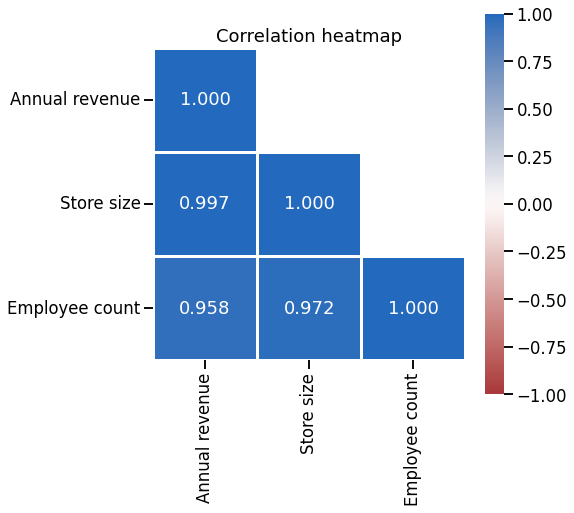

In [13]:
fig, ax = plt.subplots()

### Plotting ###
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask, k=1)] = True

sns.heatmap(
    correlation,
    annot=True,
    fmt='3.3f',
    vmin=-1,
    vmax=1,
    cmap='vlag_r',
    square=True,
    mask=mask,
    linewidths=2.5,
    ax=ax
)

### Formatting ###
ticks = [0.5, 1.5, 2.5]
labels = ['Annual revenue', 'Store size', 'Employee count']
ax.set(
    title='Correlation heatmap',
    xticks=ticks,
    xticklabels=labels,
    yticks=ticks,
    yticklabels=labels,
)

### Saving ###
fig.savefig(
    'Q6. Correlation heatmap.png',
    bbox_inches="tight",
    facecolor='white',
    dpi=150,
)


Scatter plots

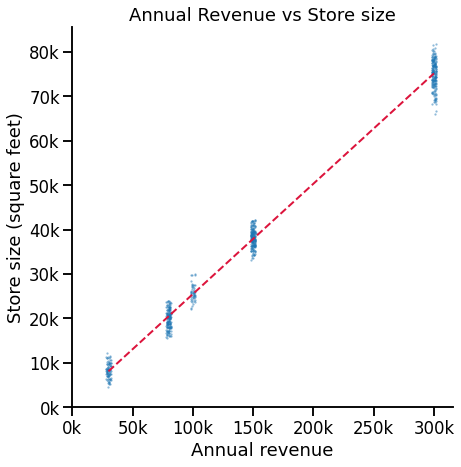

In [14]:
fig, ax = plt.subplots()
sns.despine()

### Plotting ###
sns.regplot(
    x="annual_revenue",
    y="square_footage",
    data=store,
    ax=ax,
    ci=None,
    x_jitter=2000, # Relatively small jitter to show data clusters
    y_jitter=2000,
    scatter_kws=dict(
        alpha=0.5,
        s=5,
        linewidth=0,
    ),
    line_kws=dict(
        linestyle='--',
        linewidth=2,
        color='Crimson'
    ),
)

### Formatting ###
x_ticks = np.arange(0, 301, 50)
y_ticks = np.arange(0, 81, 10)
ax.set(
    box_aspect=1,
    xticks=x_ticks * 1000,
    xticklabels=[f"{x}k" for x in x_ticks],
    yticks=y_ticks * 1000,
    yticklabels=[f"{x}k" for x in y_ticks],
    xlabel='Annual revenue',
    ylabel='Store size (square feet)',
    title='Annual Revenue vs Store size',
)

### Saving ###
fig.savefig(
    'Q6. Annual Revenue vs Store size.png',
    bbox_inches="tight",
    facecolor='white',
    dpi=150,
)

In [15]:
### Regression ###
slope, intercept = np.polyfit(
    x=store["annual_revenue"],
    y=store["square_footage"],
    deg=1
)

print(f"Slope: {slope}\nIntercept: {intercept}")

Slope: 0.24833853208067522
Intercept: 659.1618704104995


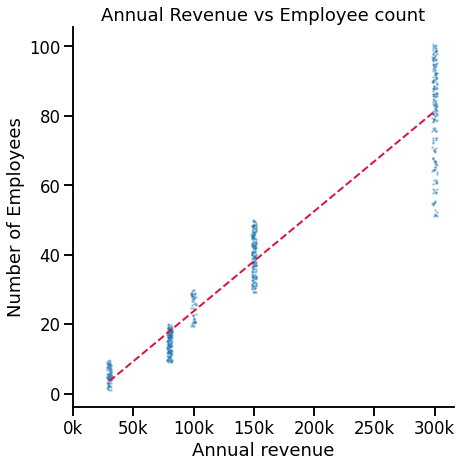

In [16]:
fig, ax = plt.subplots()
sns.despine()

sns.regplot(
    x="annual_revenue",
    y="employee_count",
    data=store,
    ax=ax,
    ci=None,
    x_jitter=2000, # Relatively small jitter to show data clusters
    y_jitter=1,
    scatter_kws=dict(
        alpha=0.5,
        s=5,
        linewidth=0,
    ),
    line_kws=dict(
        linestyle='--',
        linewidth=2,
        color='Crimson'
    ),
)

### Formatting ###
x_ticks = np.arange(0, 301, 50)
ax.set(
    box_aspect=1,
    xticks=x_ticks*1000,
    xticklabels=[f"{x}k" for x in x_ticks],
    xlabel='Annual revenue',
    ylabel='Number of Employees',
    title='Annual Revenue vs Employee count',
)

### Saving ###
fig.savefig(
    'Q6. Annual Revenue vs Employee count.png',
    bbox_inches="tight",
    facecolor='white',
    dpi=150,
)

In [17]:
### Regression ###
slope, intercept = np.polyfit(
    x=store["annual_revenue"],
    y=store["employee_count"],
    deg=1
)

print(f"Slope: {slope}\nIntercept: {intercept}")

Slope: 0.0002877959125532897
Intercept: -5.098784487225386


https://stackoverflow.com/questions/64633018/removing-white-or-light-colors-from-matplotlib-color-palette

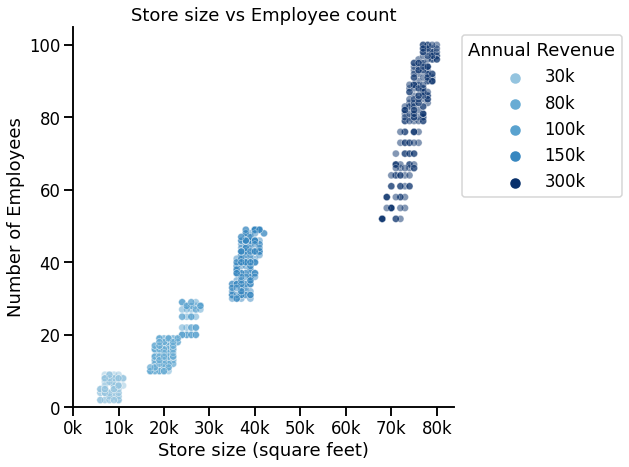

In [18]:
# 0.0 on Blues is almost pure white
colors = plt.cm.Blues(np.linspace(0.4, 1.0, 10))
new_Blues = LinearSegmentedColormap.from_list("new_Blues", colors)

fig, ax = plt.subplots()
sns.despine()

### Plotting ###
sns.scatterplot(
    x="square_footage",
    y="employee_count",
    data=store,
    ax=ax,
    hue='annual_revenue',
    palette=new_Blues,
    alpha=0.5,
    s=50
)


### Formatting ###
x_ticks = np.arange(0, 81, 10)
ax.set(
    box_aspect=1,
    xticks=x_ticks*1000,
    xticklabels=[f"{x}k" for x in x_ticks],
    ylim=(0, 105),
    xlabel='Store size (square feet)',
    ylabel='Number of Employees',
    title='Store size vs Employee count',
)
legend_values = sorted(store.annual_revenue.unique())
ax.legend(
    handles=ax._children[1:], # Some random extra dot in the default legend for some reason
    labels=[f"{int(x/1000)}k" for x in legend_values],
    title='Annual Revenue',
    loc='best',
    bbox_to_anchor=(1, 1),
)


### Saving ###
fig.savefig(
    'Q6. Store size vs Employee count.png',
    bbox_inches="tight",
    facecolor='white',
    dpi=150,
)


In [19]:
### Regression ###
slope, intercept = np.polyfit(
    x=store["square_footage"],
    y=store["employee_count"],
    deg=1
)

print(f"Slope: {slope}\nIntercept: {intercept}")

Slope: 0.001171348358096566
Intercept: -6.361371532965329


Observations:
* Almost perfect positive linear correlations between all three variables, meaning if we know any of the three we can make accurate predications about the other two
* **Do not assume correlation means causation**